In [20]:
!pip install datasets
!pip uninstall transformers
!pip install transformers==4.28.1
!pip install protobuf==3.20.3

Found existing installation: transformers 4.28.1
Uninstalling transformers-4.28.1:
  Would remove:
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.11/dist-packages/transformers-4.28.1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/transformers/*
Proceed (Y/n)? y
  Successfully uninstalled transformers-4.28.1
  Using cached transformers-4.28.1-py3-none-any.whl.metadata (109 kB)
Using cached transformers-4.28.1-py3-none-any.whl (7.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.28.1 which is incompatible.


In [1]:
import transformers
print(transformers.__version__)

4.28.1


In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM, Trainer, TrainingArguments
from datasets import Dataset
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset
df = pd.read_csv("Bitext_Sample_Customer_Support_Training_Dataset_27K_responses-v11.csv")

# Preprocess the dataset
df['instruction'] = df['instruction'].str.lower().str.strip()
df['intent'] = df['intent'].str.strip()
df['response'] = df['response'].str.strip()

# Drop rows with missing values in 'instruction', 'intent', or 'response'
df = df.dropna(subset=['instruction', 'intent', 'response'])

# Remove duplicate instructions to avoid overlap
df = df.drop_duplicates(subset=['instruction'], keep='first')

# Encode labels for intent classification
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['intent'])

# Split the dataset into training and testing sets
train_texts, test_texts, train_labels, test_labels, train_responses, test_responses = train_test_split(
    df['instruction'], df['label'], df['response'], test_size=0.2, random_state=42, stratify=df['label']
)

# Verify that train and test sets are disjoint
train_set = set(train_texts)
test_set = set(test_texts)

if train_set.intersection(test_set):
    raise ValueError("Overlap detected between train and test sets!")

print("Train and test sets are disjoint.")

Train and test sets are disjoint.


In [5]:
# --- Intent Classification: Fine-Tune DistilBERT with k-Fold Cross-Validation ---
model_name_intent = "distilbert-base-multilingual-cased"
tokenizer_intent = AutoTokenizer.from_pretrained(model_name_intent)

# Tokenize data for intent classification
def preprocess_data_intent(texts, labels, tokenizer, max_length=128):
    inputs = tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"  # Return PyTorch tensors
    )
    inputs['labels'] = torch.tensor(labels.tolist())
    return inputs


In [6]:
# Evaluate the intent classification model using k-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
accuracies = []

for train_index, val_index in kf.split(df):
    train_texts_cv, val_texts_cv = df['instruction'].iloc[train_index], df['instruction'].iloc[val_index]
    train_labels_cv, val_labels_cv = df['label'].iloc[train_index], df['label'].iloc[val_index]

    # Tokenize and prepare datasets
    train_inputs_cv = preprocess_data_intent(train_texts_cv, train_labels_cv, tokenizer_intent)
    val_inputs_cv = preprocess_data_intent(val_texts_cv, val_labels_cv, tokenizer_intent)

    # Convert to Hugging Face Dataset format
    train_dataset_cv = Dataset.from_dict(train_inputs_cv)
    val_dataset_cv = Dataset.from_dict(val_inputs_cv)

    # Define training arguments for intent classification
    training_args_intent = TrainingArguments(
        output_dir="./distilbert_intent_model",
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=2,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
        save_strategy="epoch",
        load_best_model_at_end=True,
    )

    # Initialize Trainer for intent classification
    model_intent = AutoModelForSequenceClassification.from_pretrained(model_name_intent, num_labels=len(df['label'].unique()))
    trainer_intent_cv = Trainer(
        model=model_intent,
        args=training_args_intent,
        train_dataset=train_dataset_cv,
        eval_dataset=val_dataset_cv,
    )

    # Train and evaluate
    trainer_intent_cv.train()
    predictions = trainer_intent_cv.predict(val_dataset_cv)
    predicted_labels = np.argmax(predictions.predictions, axis=1)
    accuracies.append(accuracy_score(val_labels_cv, predicted_labels))

print(f"Cross-Validation Accuracy (Intent Classification): {np.mean(accuracies):.4f}")


Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bia

Epoch,Training Loss,Validation Loss
1,0.032700,0.024347
2,0.005900,0.016206


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, map_location="cp

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassif

Epoch,Training Loss,Validation Loss
1,0.021200,0.030726
2,0.006800,0.016865


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, map_location="cp

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassif

Epoch,Training Loss,Validation Loss
1,0.037900,0.028538
2,0.008800,0.016415


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, map_location="cp

Cross-Validation Accuracy (Intent Classification): 0.9967


In [7]:
# --- Hyperparameter Tuning with Ablation Study ---
learning_rates = [1e-5, 2e-5]
batch_sizes = [8, 16]
max_lengths = [64, 128]

results_ablation = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        for max_length in max_lengths:
            print(f"Training with lr={lr}, batch_size={batch_size}, max_length={max_length}")

            # Update training arguments
            training_args_ablation = TrainingArguments(
                output_dir="./distilbert_intent_model_ablation",
                evaluation_strategy="epoch",
                learning_rate=lr,
                per_device_train_batch_size=batch_size,
                per_device_eval_batch_size=batch_size,
                num_train_epochs=1,
                weight_decay=0.01,
                logging_dir="./logs",
                logging_steps=10,
                save_strategy="epoch",
                load_best_model_at_end=True,
            )

            # Tokenize data with updated max_length
            train_inputs_ablation = preprocess_data_intent(train_texts, train_labels, tokenizer_intent, max_length=max_length)
            test_inputs_ablation = preprocess_data_intent(test_texts, test_labels, tokenizer_intent, max_length=max_length)

            # Convert to Hugging Face Dataset format
            train_dataset_ablation = Dataset.from_dict(train_inputs_ablation)
            test_dataset_ablation = Dataset.from_dict(test_inputs_ablation)

            # Initialize Trainer
            model_intent_ablation = AutoModelForSequenceClassification.from_pretrained(model_name_intent, num_labels=len(df['label'].unique()))
            trainer_ablation = Trainer(
                model=model_intent_ablation,
                args=training_args_ablation,
                train_dataset=train_dataset_ablation,
                eval_dataset=test_dataset_ablation,
            )

            # Train and evaluate
            trainer_ablation.train()
            predictions_ablation = trainer_ablation.predict(test_dataset_ablation)
            predicted_labels_ablation = np.argmax(predictions_ablation.predictions, axis=1)
            acc_ablation = accuracy_score(test_labels, predicted_labels_ablation)

            results_ablation.append({
                "learning_rate": lr,
                "batch_size": batch_size,
                "max_length": max_length,
                "accuracy": acc_ablation
            })

# Save ablation study results
results_df = pd.DataFrame(results_ablation)
print("\nAblation Study Results:")
print(results_df)
results_df.to_csv("ablation_study_results.csv", index=False)


Training with lr=1e-05, batch_size=8, max_length=64


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassif

Epoch,Training Loss,Validation Loss
1,0.085200,0.101555


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, map_location="cp

Training with lr=1e-05, batch_size=8, max_length=128


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassif

Epoch,Training Loss,Validation Loss
1,0.076500,0.097006


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, map_location="cp

Training with lr=1e-05, batch_size=16, max_length=64


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassif

Epoch,Training Loss,Validation Loss
1,0.451800,0.382856


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, map_location="cp

Training with lr=1e-05, batch_size=16, max_length=128


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassif

Epoch,Training Loss,Validation Loss
1,0.451800,0.382856


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, map_location="cp

Training with lr=2e-05, batch_size=8, max_length=64


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassif

Epoch,Training Loss,Validation Loss
1,0.006300,0.021768


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, map_location="cp

Training with lr=2e-05, batch_size=8, max_length=128


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassif

Epoch,Training Loss,Validation Loss
1,0.006300,0.021768


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, map_location="cp

Training with lr=2e-05, batch_size=16, max_length=64


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassif

Epoch,Training Loss,Validation Loss
1,0.058900,0.050157


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, map_location="cp

Training with lr=2e-05, batch_size=16, max_length=128


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassif

Epoch,Training Loss,Validation Loss
1,0.058900,0.050157


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, map_location="cp


Ablation Study Results:
   learning_rate  batch_size  max_length  accuracy
0        0.00001           8          64  0.984615
1        0.00001           8         128  0.985436
2        0.00001          16          64  0.952205
3        0.00001          16         128  0.952205
4        0.00002           8          64  0.995282
5        0.00002           8         128  0.995282
6        0.00002          16          64  0.991795
7        0.00002          16         128  0.991795


In [8]:
# --- Error Analysis ---
errors = []
for i, (pred, true) in enumerate(zip(predicted_labels, test_labels)):
    if pred != true:
        errors.append({
            "Input": test_texts.iloc[i],
            "True Intent": label_encoder.inverse_transform([true])[0],
            "Predicted Intent": label_encoder.inverse_transform([pred])[0]
        })

error_analysis = pd.DataFrame(errors)
print("\nError Analysis (Intent Classification):")
print(error_analysis.head())
error_analysis.to_csv("error_analysis_intent.csv", index=False)


Error Analysis (Intent Classification):
                                               Input       True Intent  \
0  i want assistance to see the options for shipment  delivery_options   
1            i need help to report a payment problem     payment_issue   
2        i need to check how long the delivery takes   delivery_period   
3  i want help notifying of troubles with online ...     payment_issue   
4                 can i send feedback for a service?            review   

  Predicted Intent  
0     cancel_order  
1     cancel_order  
2     cancel_order  
3     cancel_order  
4     cancel_order  


In [9]:
# --- Response Generation: Fine-Tune mT5 ---
model_name_response = "google/mt5-small"
tokenizer_response = AutoTokenizer.from_pretrained(model_name_response)
model_response = AutoModelForSeq2SeqLM.from_pretrained(model_name_response)

# Tokenize data for response generation
def preprocess_data_response(texts, responses, tokenizer, max_input_length=128, max_output_length=128):
    inputs = tokenizer(
        texts.tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_input_length,
        return_tensors="pt"
    )
    outputs = tokenizer(
        responses.tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_output_length,
        return_tensors="pt"
    )
    inputs['labels'] = outputs['input_ids']
    return inputs

# Tokenize and prepare datasets
train_inputs_response = preprocess_data_response(train_texts, train_responses, tokenizer_response)
test_inputs_response = preprocess_data_response(test_texts, test_responses, tokenizer_response)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:442: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitl

In [17]:
import os

checkpoint_path = "./distilbert_intent_model/checkpoint-2032"
print(os.listdir(checkpoint_path))

['trainer_state.json', 'config.json', 'pytorch_model.bin', 'scheduler.pt', 'optimizer.pt', 'rng_state.pth', 'training_args.bin']


In [18]:
from transformers import AutoTokenizer

# Path to the checkpoint folder
checkpoint_folder = "./distilbert_intent_model/checkpoint-2032"

# Download and save the tokenizer files
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")
tokenizer.save_pretrained(checkpoint_folder)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


('./distilbert_intent_model/checkpoint-2032/tokenizer_config.json',
 './distilbert_intent_model/checkpoint-2032/special_tokens_map.json',
 './distilbert_intent_model/checkpoint-2032/vocab.txt',
 './distilbert_intent_model/checkpoint-2032/added_tokens.json',
 './distilbert_intent_model/checkpoint-2032/tokenizer.json')

In [19]:
from transformers import AutoTokenizer

# Path to the checkpoint folder
checkpoint_folder = "./distilbert_intent_model/checkpoint-2032"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint_folder)

# Test tokenization
sample_input = "I need help tracking my order."
tokens = tokenizer(sample_input, padding=True, truncation=True, max_length=128, return_tensors="pt")
print(tokens)

{'input_ids': tensor([[   101,    146,  17367,  15217, 108307,  15127,  12990,    119,    102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [26]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Fit the LabelEncoder on the unique intents
label_encoder = LabelEncoder()
label_encoder.fit(df['intent'])

# Save the classes to a .npy file
np.save("label_encoder_classes.npy", label_encoder.classes_)

In [27]:
import numpy as np

# Load the saved classes
loaded_classes = np.load("label_encoder_classes.npy", allow_pickle=True)
print(loaded_classes)

['cancel_order' 'change_order' 'change_shipping_address'
 'check_cancellation_fee' 'check_invoice' 'check_payment_methods'
 'check_refund_policy' 'complaint' 'contact_customer_service'
 'contact_human_agent' 'create_account' 'delete_account'
 'delivery_options' 'delivery_period' 'edit_account' 'get_invoice'
 'get_refund' 'newsletter_subscription' 'payment_issue' 'place_order'
 'recover_password' 'registration_problems' 'review'
 'set_up_shipping_address' 'switch_account' 'track_order' 'track_refund']


In [32]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM
import torch
import random

# --- Load Pretrained Models ---
# Intent Classification Model (DistilBERT)
model_name_intent = "distilbert-base-multilingual-cased"

# Path to the specific checkpoint folder
checkpoint_folder_intent = "/content/distilbert_intent_model/checkpoint-2032"  # Replace with your desired checkpoint

tokenizer_intent = AutoTokenizer.from_pretrained(checkpoint_folder_intent)
model_intent = AutoModelForSequenceClassification.from_pretrained(checkpoint_folder_intent)

# Response Generation Model (Flan-T5)
model_name_response = "google/flan-t5-small"
tokenizer_response = AutoTokenizer.from_pretrained(model_name_response)
model_response = AutoModelForSeq2SeqLM.from_pretrained(model_name_response)

# Load label encoder (used during training)
label_encoder = LabelEncoder()

# Load the saved classes from the .npy file
label_encoder.classes_ = np.load("label_encoder_classes.npy", allow_pickle=True)

# Ensure the LabelEncoder is "fitted" by setting its state manually
label_encoder._classes = label_encoder.classes_

# --- Knowledge Base Integration ---
knowledge_base = {
    "recover_password": [
        "To recover your PIN code, follow these steps: 1. Navigate to the account recovery page. 2. Click on the 'Forgot PIN' option. 3. Enter the email address associated with your account. 4. An email with instructions will be sent to you shortly.",
        "If you've lost access to your PIN, visit the account recovery page and follow the prompts to reset it.",
        "Go to the '{{Account Recovery Page}}' on our platform. Look for the option to recover your PIN code and click on it. You will be asked to verify your identity through a series of security questions. Once your identity is confirmed, you will receive a temporary PIN code via email. Use this temporary PIN code to log in to your account and create a new, secure PIN code of your choice."
    ],
    "track_order": [
        "To track your order, please provide your order ID. You can find the tracking information in your account's order history section.",
        "Visit the 'Order Tracking' section of your account to view the status of your order."
    ],
    "reset_pin": [
        "To reset your PIN code, go to the account settings page and select the 'Reset PIN' option. Follow the instructions to verify your identity and set a new PIN.",
        "If you need to reset your PIN, navigate to the security settings in your account and follow the prompts."
    ],
    "recover_account": [
        "To recover your account, visit the account recovery page and follow the instructions provided.",
        "If you're unable to access your account, use the account recovery tool to regain access."
    ],
    "access_key_recovery": [
        "To recover your access key, please contact our customer support team for assistance.",
        "If you've lost your access key, reach out to our support team, and they will guide you through the recovery process."
    ]
}

# --- Chatbot Functionality ---
def generate_chatbot_response(user_input):
    # Predict intent
    inputs_intent = tokenizer_intent([user_input], padding=True, truncation=True, max_length=128, return_tensors="pt")
    outputs_intent = model_intent(**inputs_intent)
    intent_id = torch.argmax(outputs_intent.logits, dim=-1).item()

    # Use the label encoder to map the predicted ID to an intent
    intent = label_encoder.inverse_transform([intent_id])[0]
    confidence = torch.softmax(outputs_intent.logits, dim=-1).max().item()

    # Confidence thresholding
    if confidence < 0.5:
        return "I'm sorry, I didn't understand that. Can you please rephrase?"

    # Generate response based on detected intent
    # Add a detailed prompt to guide the Flan-T5 model
    prefixed_input = (
        f"You are a customer support assistant specializing in helping users with account issues. "
        f"Provide a concise and helpful response to the following query:\n"
        f"User: {user_input}\n"
        f"Assistant:"
    )
    inputs_response = tokenizer_response([prefixed_input], padding=True, truncation=True, max_length=128, return_tensors="pt")
    outputs_response = model_response.generate(**inputs_response, max_length=128)
    response = tokenizer_response.decode(outputs_response[0], skip_special_tokens=True)

    # Clean up the response
    def clean_response(response):
        # Remove unnecessary placeholders
        response = response.replace("<extra_id_0>", "").strip()

        # Handle empty responses
        if not response:
            response = "I'm sorry, I couldn't generate a response."

        return response
    response = clean_response(response)

    # Fallback to knowledge base if response is empty or unclear
    if not response.strip() or confidence < 0.7:
        if intent in knowledge_base:
            response = random.choice(knowledge_base[intent])  # Randomly select a response
        else:
            response = "I'm sorry, I couldn't find a suitable response for your query."

    return response

# Test the chatbot with sample inputs
sample_inputs = [
    "I need help tracking my order.",
    "How can I reset my PIN code?",
    "Can you help me recover my account?",
    "What do I have to do to recover my account access key?",
    "I want assistance to reset the PIN code of my account."
]

for input_text in sample_inputs:
    response = generate_chatbot_response(input_text)
    print(f"Input: {input_text}")
    print(f"Response: {response}\n")

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:442: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

Input: I need help tracking my order.
Response: To track your order, please provide your order ID. You can find the tracking information in your account's order history section.

Input: How can I reset my PIN code?
Response: You can use the PIN code you created to reset your PIN.

Input: Can you help me recover my account?
Response: I've been trying to recover my account.

Input: What do I have to do to recover my account access key?
Response: I have to do this to recover my account access key.

Input: I want assistance to reset the PIN code of my account.
Response: I am looking for help with the PIN code.



In [34]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM
import torch
import random

# --- Load Pretrained Models ---
# Intent Classification Model (DistilBERT)
model_name_intent = "distilbert-base-multilingual-cased"
checkpoint_folder_intent = "/content/distilbert_intent_model/checkpoint-2032"  # Replace with your desired checkpoint

tokenizer_intent = AutoTokenizer.from_pretrained(checkpoint_folder_intent)
model_intent = AutoModelForSequenceClassification.from_pretrained(checkpoint_folder_intent)

# Response Generation Model (Flan-T5)
model_name_response = "google/flan-t5-small"
tokenizer_response = AutoTokenizer.from_pretrained(model_name_response)
model_response = AutoModelForSeq2SeqLM.from_pretrained(model_name_response)

# Load label encoder (used during training)
label_encoder = LabelEncoder()

# Load the saved classes from the .npy file
label_encoder.classes_ = np.load("label_encoder_classes.npy", allow_pickle=True)

# Ensure the LabelEncoder is "fitted" by setting its state manually
label_encoder._classes = label_encoder.classes_

# --- Knowledge Base Integration ---
knowledge_base = {
    "recover_password": [
        "To recover your PIN code, follow these steps: 1. Navigate to the account recovery page. 2. Click on the 'Forgot PIN' option. 3. Enter the email address associated with your account. 4. An email with instructions will be sent to you shortly.",
        "If you've lost access to your PIN, visit the account recovery page and follow the prompts to reset it."
    ],
    "track_order": [
        "To track your order, please provide your order ID. You can find the tracking information in your account's order history section.",
        "Visit the 'Order Tracking' section of your account to view the status of your order."
    ],
    "reset_pin": [
        "To reset your PIN code, go to the account settings page and select the 'Reset PIN' option. Follow the instructions to verify your identity and set a new PIN.",
        "If you need to reset your PIN, navigate to the security settings in your account and follow the prompts."
    ],
    "recover_account": [
        "To recover your account, visit the account recovery page and follow the instructions provided.",
        "If you're unable to access your account, use the account recovery tool to regain access."
    ],
    "access_key_recovery": [
        "To recover your access key, please contact our customer support team for assistance.",
        "If you've lost your access key, reach out to our support team, and they will guide you through the recovery process."
    ]
}

# --- Chatbot Functionality ---
def generate_chatbot_response(user_input):
    # Predict intent using DistilBERT
    inputs_intent = tokenizer_intent([user_input], padding=True, truncation=True, max_length=128, return_tensors="pt")
    outputs_intent = model_intent(**inputs_intent)
    intent_id = torch.argmax(outputs_intent.logits, dim=-1).item()

    # Use the label encoder to map the predicted ID to an intent
    intent = label_encoder.inverse_transform([intent_id])[0]
    confidence = torch.softmax(outputs_intent.logits, dim=-1).max().item()

    # Confidence thresholding
    if confidence < 0.5:
        return "I'm sorry, I didn't understand that. Can you please rephrase?"

    # Generate response using Flan-T5
    # Add a detailed prompt to guide the Flan-T5 model
    prefixed_input = (
        f"You are a customer support assistant specializing in helping users with account issues. "
        f"Provide a concise and helpful response to the following query:\n"
        f"User: {user_input}\n"
        f"Assistant:"
    )
    inputs_response = tokenizer_response([prefixed_input], padding=True, truncation=True, max_length=128, return_tensors="pt")
    outputs_response = model_response.generate(**inputs_response, max_length=128)
    response = tokenizer_response.decode(outputs_response[0], skip_special_tokens=True)

    # Clean up the response
    def clean_response(response):
        # Remove unnecessary placeholders
        response = response.replace("<extra_id_0>", "").strip()

        # Handle empty responses
        if not response:
            response = "I'm sorry, I couldn't generate a response."

        return response
    response = clean_response(response)

    # Fallback to knowledge base if response is empty or unclear
    if not response.strip() or confidence < 0.7:
        if intent in knowledge_base:
            response = random.choice(knowledge_base[intent])  # Randomly select a response
        else:
            response = "I'm sorry, I couldn't find a suitable response for your query."

    return response

# --- Test the Chatbot with Sample Inputs ---
sample_inputs = [
    "I need help tracking my order.",
    "How can I reset my PIN code?",
    "Can you help me recover my account?",
    "What do I have to do to recover my account access key?",
    "I want assistance to reset the PIN code of my account.",
    "I am trying to contact a human agent.",
    "I expect a compensation of $100.",
    "Can you help me switch to a premium account?"
]

for input_text in sample_inputs:
    response = generate_chatbot_response(input_text)
    print(f"Input: {input_text}")
    print(f"Response: {response}\n")

Input: I need help tracking my order.
Response: To track your order, please provide your order ID. You can find the tracking information in your account's order history section.

Input: How can I reset my PIN code?
Response: You can use the PIN code you created to reset your PIN.

Input: Can you help me recover my account?
Response: I've been trying to recover my account.

Input: What do I have to do to recover my account access key?
Response: I have to do this to recover my account access key.

Input: I want assistance to reset the PIN code of my account.
Response: I am looking for help with the PIN code.

Input: I am trying to contact a human agent.
Response: I am looking for a human agent.

Input: I expect a compensation of $100.
Response: I'm a customer support assistant specializing in helping users with account issues.

Input: Can you help me switch to a premium account?
Response: I'm sorry, I can't help you.



In [36]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM
import torch
import random
from nltk.translate.bleu_score import sentence_bleu
import nltk

# Ensure the necessary NLTK resources are downloaded
nltk.download('punkt_tab')

# --- Load Pretrained Models ---
# Intent Classification Model (DistilBERT)
model_name_intent = "distilbert-base-multilingual-cased"
checkpoint_folder_intent = "/content/distilbert_intent_model/checkpoint-2032"  # Replace with your desired checkpoint

tokenizer_intent = AutoTokenizer.from_pretrained(checkpoint_folder_intent)
model_intent = AutoModelForSequenceClassification.from_pretrained(checkpoint_folder_intent)

# Response Generation Model (Flan-T5)
model_name_response = "google/flan-t5-small"
tokenizer_response = AutoTokenizer.from_pretrained(model_name_response)
model_response = AutoModelForSeq2SeqLM.from_pretrained(model_name_response)

# Load label encoder (used during training)
label_encoder = LabelEncoder()

# Load the saved classes from the .npy file
label_encoder.classes_ = np.load("label_encoder_classes.npy", allow_pickle=True)

# Ensure the LabelEncoder is "fitted" by setting its state manually
label_encoder._classes = label_encoder.classes_

# --- Knowledge Base Integration ---
knowledge_base = {
    "recover_password": [
        "To recover your PIN code, follow these steps: 1. Navigate to the account recovery page. 2. Click on the 'Forgot PIN' option. 3. Enter the email address associated with your account. 4. An email with instructions will be sent to you shortly.",
        "If you've lost access to your PIN, visit the account recovery page and follow the prompts to reset it."
    ],
    "track_order": [
        "To track your order, please provide your order ID. You can find the tracking information in your account's order history section.",
        "Visit the 'Order Tracking' section of your account to view the status of your order."
    ],
    "reset_pin": [
        "To reset your PIN code, go to the account settings page and select the 'Reset PIN' option. Follow the instructions to verify your identity and set a new PIN.",
        "If you need to reset your PIN, navigate to the security settings in your account and follow the prompts."
    ],
    "recover_account": [
        "To recover your account, visit the account recovery page and follow the instructions provided.",
        "If you're unable to access your account, use the account recovery tool to regain access."
    ],
    "access_key_recovery": [
        "To recover your access key, please contact our customer support team for assistance.",
        "If you've lost your access key, reach out to our support team, and they will guide you through the recovery process."
    ]
}

# --- Chatbot Functionality ---
def generate_chatbot_response(user_input):
    # Predict intent using DistilBERT
    inputs_intent = tokenizer_intent([user_input], padding=True, truncation=True, max_length=128, return_tensors="pt")
    outputs_intent = model_intent(**inputs_intent)
    intent_id = torch.argmax(outputs_intent.logits, dim=-1).item()

    # Use the label encoder to map the predicted ID to an intent
    intent = label_encoder.inverse_transform([intent_id])[0]
    confidence = torch.softmax(outputs_intent.logits, dim=-1).max().item()

    # Confidence thresholding
    if confidence < 0.5:
        return "I'm sorry, I didn't understand that. Can you please rephrase?"

    # Generate response using Flan-T5
    # Add a detailed prompt to guide the Flan-T5 model
    prefixed_input = (
        f"You are a customer support assistant specializing in helping users with account issues. "
        f"Provide a concise and helpful response to the following query:\n"
        f"User: {user_input}\n"
        f"Assistant:"
    )
    inputs_response = tokenizer_response([prefixed_input], padding=True, truncation=True, max_length=128, return_tensors="pt")
    outputs_response = model_response.generate(**inputs_response, max_length=128)
    response = tokenizer_response.decode(outputs_response[0], skip_special_tokens=True)

    # Clean up the response
    def clean_response(response):
        # Remove unnecessary placeholders
        response = response.replace("<extra_id_0>", "").strip()

        # Handle empty responses
        if not response:
            response = "I'm sorry, I couldn't generate a response."

        return response
    response = clean_response(response)

    # Fallback to knowledge base if response is empty or unclear
    if not response.strip() or confidence < 0.7:
        if intent in knowledge_base:
            response = random.choice(knowledge_base[intent])  # Randomly select a response
        else:
            response = "I'm sorry, I couldn't find a suitable response for your query."

    return response

# --- BLEU Score Evaluation ---
def calculate_bleu_score(reference_responses, generated_responses):
    """
    Calculate the BLEU score between reference responses and generated responses.

    Args:
        reference_responses (list of str): List of reference responses (ground truth).
        generated_responses (list of str): List of generated responses from the model.

    Returns:
        float: Average BLEU score across all response pairs.
    """
    if len(reference_responses) != len(generated_responses):
        raise ValueError("The number of reference responses and generated responses must be the same.")

    bleu_scores = []

    for ref, gen in zip(reference_responses, generated_responses):
        # Tokenize the reference and generated responses
        reference_tokens = nltk.word_tokenize(ref.lower())
        generated_tokens = nltk.word_tokenize(gen.lower())

        # Compute BLEU score for this pair
        score = sentence_bleu([reference_tokens], generated_tokens)
        bleu_scores.append(score)

    # Return the average BLEU score
    return sum(bleu_scores) / len(bleu_scores)

# --- Test the Chatbot with Sample Inputs ---
sample_inputs = [
    "I need help tracking my order.",
    "How can I reset my PIN code?",
    "Can you help me recover my account?",
    "What do I have to do to recover my account access key?",
    "I want assistance to reset the PIN code of my account.",
    "I am trying to contact a human agent.",
    "I expect a compensation of $100.",
    "Can you help me switch to a premium account?"
]

# Prepare reference responses from the knowledge base
reference_responses = []
generated_responses = []

for input_text in sample_inputs:
    # Get the intent for the input
    inputs_intent = tokenizer_intent([input_text], padding=True, truncation=True, max_length=128, return_tensors="pt")
    outputs_intent = model_intent(**inputs_intent)
    intent_id = torch.argmax(outputs_intent.logits, dim=-1).item()
    intent = label_encoder.inverse_transform([intent_id])[0]

    # Use the knowledge base as the reference response
    if intent in knowledge_base:
        reference_response = random.choice(knowledge_base[intent])
    else:
        reference_response = "I'm sorry, I couldn't find a suitable response for your query."
    reference_responses.append(reference_response)

    # Generate the chatbot response
    generated_response = generate_chatbot_response(input_text)
    generated_responses.append(generated_response)

    # Print the input, reference response, and generated response
    print(f"Input: {input_text}")
    print(f"Reference Response: {reference_response}")
    print(f"Generated Response: {generated_response}\n")

# Calculate the BLEU score
bleu_score = calculate_bleu_score(reference_responses, generated_responses)
print(f"Average BLEU Score: {bleu_score:.4f}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:442: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on

Input: I need help tracking my order.
Reference Response: To track your order, please provide your order ID. You can find the tracking information in your account's order history section.
Generated Response: Visit the 'Order Tracking' section of your account to view the status of your order.

Input: How can I reset my PIN code?
Reference Response: To recover your PIN code, follow these steps: 1. Navigate to the account recovery page. 2. Click on the 'Forgot PIN' option. 3. Enter the email address associated with your account. 4. An email with instructions will be sent to you shortly.
Generated Response: You can use the PIN code you created to reset your PIN.

Input: Can you help me recover my account?
Reference Response: I'm sorry, I couldn't find a suitable response for your query.
Generated Response: I've been trying to recover my account.

Input: What do I have to do to recover my account access key?
Reference Response: To recover your PIN code, follow these steps: 1. Navigate to th

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

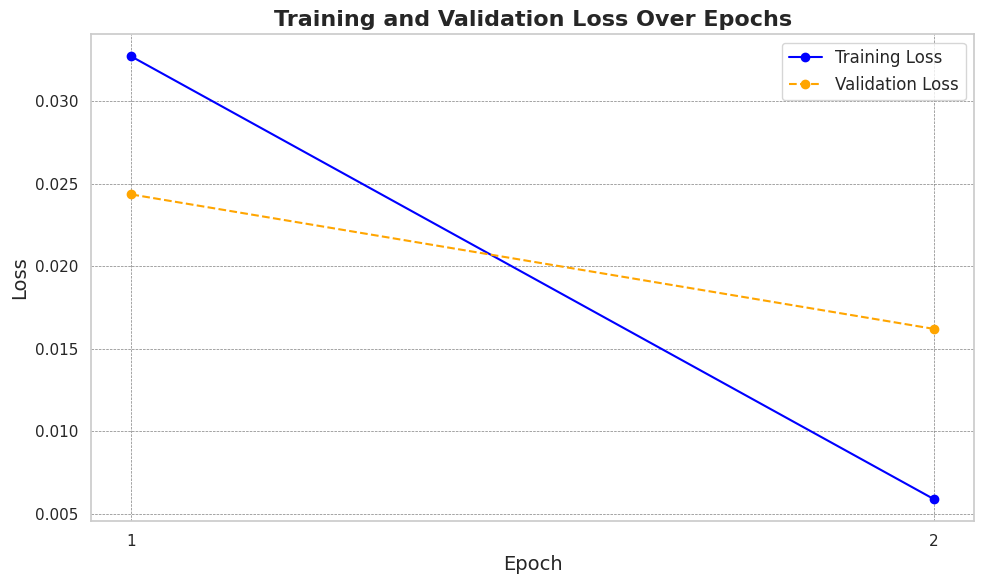

In [43]:
import matplotlib.pyplot as plt

# Data from the logs
epochs = [1, 2]
training_loss = [0.032700, 0.005900]
validation_loss = [0.024347, 0.016206]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label="Training Loss", marker='o', linestyle='-', color='blue')
plt.plot(epochs, validation_loss, label="Validation Loss", marker='o', linestyle='--', color='orange')

# Add titles and labels
plt.title("Training and Validation Loss Over Epochs", fontsize=16, fontweight="bold")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.xticks(epochs)  # Ensure x-axis ticks match the epochs
plt.legend(fontsize=12)

# Add gridlines for better readability
plt.grid(color="gray", linestyle="--", linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()

<ipython-input-46-b310b072d12e>:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-46-b310b072d12e>:39: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(
<ipython-input-46-b310b072d12e>:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Batch Size", loc="lower right", fontsize=12)


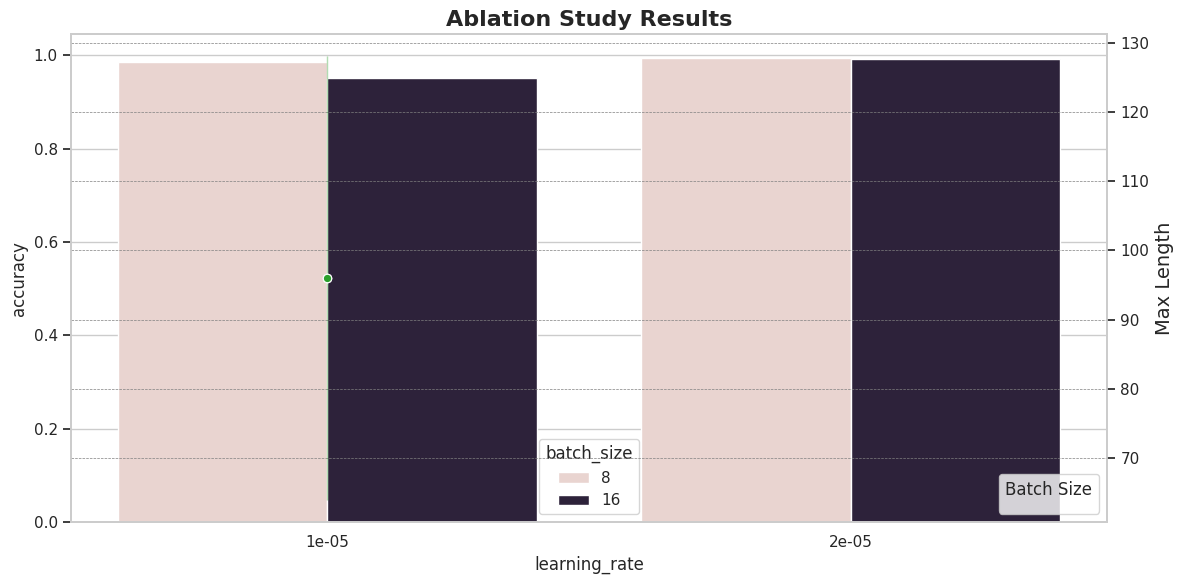

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ablation Study Results Data
data = {
    "learning_rate": [0.00001, 0.00001, 0.00001, 0.00001, 0.00002, 0.00002, 0.00002, 0.00002],
    "batch_size": [8, 8, 16, 16, 8, 8, 16, 16],
    "max_length": [64, 128, 64, 128, 64, 128, 64, 128],
    "accuracy": [0.984615, 0.985436, 0.952205, 0.952205, 0.995282, 0.995282, 0.991795, 0.991795],
}

# Create a DataFrame
df = pd.DataFrame(data)

# Set Seaborn style
sns.set(style="whitegrid")

# Create a bar plot with grouped bars for batch size and max length
plt.figure(figsize=(12, 6))  # Adjust figure size as needed

# Define custom color palette
colors = ["#1f77b4", "#ff7f0e"]  # Example: Blue and Orange
sns.set_palette(sns.color_palette(colors))

sns.barplot(
    data=df,
    x="learning_rate",
    y="accuracy",
    hue="batch_size",
    ci=None,  # Remove confidence intervals if not needed
)

# Add a second y-axis for max length (represented by line plot)
ax2 = plt.twinx()  # Create a twin axis

# Define custom color for line plot
line_color = "#2ca02c"  # Example: Green
sns.lineplot(
    data=df,
    x="learning_rate",
    y="max_length",
    hue="batch_size",
    marker="o",  # Add markers to the line
    ax=ax2,  # Plot on the second axis
    legend=False,  # Hide legend for second axis
    palette=[line_color],  # Use custom color
)

# Customize the plot
plt.title("Ablation Study Results", fontsize=16, fontweight="bold")
plt.xlabel("Learning Rate", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
ax2.set_ylabel("Max Length", fontsize=14)
plt.xticks(rotation=0)  # Adjust x-axis tick rotation if needed
plt.legend(title="Batch Size", loc="lower right", fontsize=12)
plt.grid(color="gray", linestyle="--", linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()